<a href="https://colab.research.google.com/github/stazam/DTSE-project/blob/main/DTSE_steam_data_reviews_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model bulding**

First we will start by preprocessing text variables in datasets:

1. checking english language - we will be modelling only english written variables
2. removing some special characters
3. 

We will try to use various models for user_review category prediction. Types of models which we will consider:

1. Bidirectional LSTM layer (+ CNN layer) with embedding layer without removing stop words and lematization 
2. Bidirectional LSTM layer (+ CNN layer) with embedding layer with using a stop wrods and lematization 
3. BERT - transformer for text classification without pretrained embeddings without removing stop words and lematization. 
4. BERT - transformer for text classification with pretrained embeddings without removing stop words and lematization.

Also we will use stacking method to incorporate information from varibales **year**. 

At the end we create **predict_pipeline** function for prediction, which will consist of preprocessing and prediction part.



In [1]:
import tensorflow as tf
import keras
import sys
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling1D, Flatten, Dropout
from keras import optimizers

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

!pip install langdetect
from langdetect import detect

import re 

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 981 kB 5.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=7fc19e11b334b2546ba1a7f1b645a76cc2f99418777b36bafeaf4741108819ab
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
sys.path.append('/content/drive/MyDrive/DTSE-data/Python-files')
from help_functions import *

In [3]:
df_train_merged = pd.read_pickle("/content/drive/MyDrive/DTSE-data/data-files/df_train_merged.pkl")
df_test_merged = pd.read_pickle("/content/drive/MyDrive/DTSE-data/data-files/df_test_merged.pkl")

# 1. **Bidirectional LSTM** (+ CNN) without removing stop words and lematization




# **Text** preprocessing

We will check for language of string variables. Since we have seen during **game_overview** file inspection that both *developer, publisher* and also *title* are english words, we do not need to check them. But we have to inspect **user_review** for english language.

MOje poznamky:
1. dorobit text preprocessing - spravit jednu funkciu, pozriet ci sa odsatranuje spatne lomitko
2. LSTM model bez lmetozacie a stop words
3. vyetrenie modelu a pridat aj aky cas trval trening
4. knn imputer doplnit premennu year - tuto si dat pozor na to aby mi to vratilo len year premennu
5. model + zahrnutie year premennje a pouzitie asi logistickej regresie
6. BERT bez leatizacie a stop words
7. BERT s lematizaciu s stop words
8. vysetri modely
9. cela funkcia ktora mi spravi od preprocessingu vsetko az po preridkciu  

In [4]:
def check_language(x):
    
    try:
      return detect(x) 
    except:
        return None

df_train_merged['language'] = df_train_merged.user_review.apply(lambda x: check_language(x))

In [5]:
print('{} rows from train dataset in different language were removed'.format(sum(df_train_merged.language.values != 'en')))
df_train_merged = df_train_merged.loc[df_train_merged.language == 'en',:]

214 rows from train dataset in different language were removed


We can see we loose 214 rows with user_reviews in differnt languages.

In [6]:
#symbols = set([y for x in df_train_merged.user_review.values for y in x if not y.isalnum()])
#print(symbols)
symbols_up = {'⭐', '`', 'ี', '／', '“', '⟶', '‘', '˘', '\u2007', '□', '♬', '\xad', '«', '้', '☢', '[', '¯', '＼', ']', '☠', 'Ⓚ', 'ั', '¶', '€', '⌐', '^', '‹', '⁀', '･', '£', '%', '=', ' ', '*', '¬', '▀', '━', '♪', '⌬', '∞', '&', ';', '”', '・', '▒', '+', '☐', '{', '¨', '⌠', '☹', '\xa0', '｜', '~', '？', '」', '¿', '¢', '่', '|', '◕', '@', '‡', '⟵', '☻', '·', '≠', '´', '☑', '✎', '۞', '͠', '˚', '✖', '●', '✦', '✰', '⋎', '͜', '✫', '■', '✩', '،', '┐', '►', "'", '_', '→', '❤', '§', '︵', '░', '✌', '▽', '•', '！', '▲', '█', '?', '▐', '˜', '͟', '}', '♥', '▄', '☣', '＿', '〃', '\u3000', '＾', '☼', '★', '®', '┌', '¤', '☺', '\\', '▌', 'ู', '「', '¡', '’', '▼', '¦', '°', '┳', '…', '#', '±', '～', '\u200b', '>', '⚠', '⌒', '‰', '<', '©', '✓', '‵', '™',  'ื', '\ufeff', 'ⓘ', '。', '‿', '︻', '͡', 'Ⓞ', '↑', '/', '¥', '$', '⊂', '═', '♫', '☆', 'ิ', '†', '̶', '↓', '✔', '┻'}

In [7]:
def is_capital(x):
  
  temp = sum([letter.isupper() for letter in x])

  if temp > 2:
    return x.lower()
  else:
    return x    

text = "soThis somethingElse is    I'm He's and PROBABLy he'll be a ⟶   SUPER  it\\'s not what\\\\'s   somethingTogether"
print("This is text BEFORE preprocessing: {}".format(text))

text = re.sub(r"(\\+')","'",text)
text = text.replace("'s"," is").replace("'re"," are").replace("'ll",' will').replace("'m",' am').strip()
if text[0] != text[0].upper():
   text = text.replace(text[0],text[0].upper(),1)
text =  ' '.join([is_capital(x) for x in text.split()])
text = ' '.join(re.findall('[A-Z][^A-Z]*', text))
for x in symbols_up:
    text = text.replace(x,' ')
text = re.sub(r"\s{2,}", " ",text)

print("This is text AFTER preprocessing: {}".format(text))

This is text BEFORE preprocessing: soThis somethingElse is    I'm He's and PROBABLy he'll be a ⟶   SUPER  it\'s not what\\'s   somethingTogether
This is text AFTER preprocessing: So This something Else is I am He is and probably he will be a super it is not what is something Together


In [8]:
def preprocess_data(X):

  symbols_up = {'♥','♥','⭐', '`', 'ี', '／', '“', '⟶', '‘', '˘', '\u2007', '□', '♬', '\xad', '«', '้', '☢', '[', '¯', '＼', ']', '☠', 'Ⓚ', 'ั', '¶', '€', '⌐', '^', '‹', '⁀', '･', '£', '%', '=', ' ', '*', '¬', '▀', '━', '♪', '⌬', '∞', '&', ';', '”', '・', '▒', '+', '☐', '{', '¨', '⌠', '☹', '\xa0', '｜', '~', '？', '」', '¿', '¢', '่', '|', '◕', '@', '‡', '⟵', '☻', '·', '≠', '´', '☑', '✎', '۞', '͠', '˚', '✖', '●', '✦', '✰', '⋎', '͜', '✫', '■', '✩', '،', '┐', '►', "'", '_', '→', '❤', '§', '︵', '░', '✌', '▽', '•', '！', '▲', '█', '?', '▐', '˜', '͟', '}', '♥', '▄', '☣', '＿', '〃', '\u3000', '＾', '☼', '★', '®', '┌', '¤', '☺', '\\', '▌', 'ู', '「', '¡', '’', '▼', '¦', '°', '┳', '…', '#', '±', '～', '\u200b', '>', '⚠', '⌒', '‰', '<', '©', '✓', '‵', '™',  'ื', '\ufeff', 'ⓘ', '。', '‿', '︻', '͡', 'Ⓞ', '↑', '/', '¥', '$', '⊂', '═', '♫', '☆', 'ิ', '†', '̶', '↓', '✔', '┻'}

  #check for english language
  X['language'] = X.user_review.apply(lambda x: check_language(x))
  X = X.loc[X.language == 'en',:].drop(columns = ['language'])

  user_reviews = []
  for review in X.user_review.values:
    
    #removing vaste character "\'" and "\\'" and "\\\'"...
    review = re.sub(r"(\\+')","'",review)
    #high level - stematization
    review = review.replace("\'","'").replace("'s"," is").replace("'re"," are").replace("'ll",' will').replace("'m",' am')
    #adding capital letter to the first letter of sequence
    if review[0] != review[0].upper():
       review = review.replace(review[0],review[0].upper(),1)
    #Replacing capital words with lower letters
    review = ' '.join([is_capital(x) for x in review.split()])
    #handling the camel case words, i.e. ToHis --> To His
    review = ' '.join(re.findall('[A-Z][^A-Z]*', review))
    #removing vaste characters
    for x in symbols_up:
        review = review.replace(x,' ')
    review = re.sub(r"\s{2,}", " ",review)
    user_reviews.append(review)

  X.user_review = user_reviews  
  return X

We will check the variables **tags, developer, publisher, title** and preprocess these data as well. 


In [9]:
%%time

X = df_train_merged
X = preprocess_data(X)

X.tags = X.tags.apply(lambda x: x.replace("\'",'')[1:-1])
X.tags


CPU times: user 1min 40s, sys: 1.01 s, total: 1min 41s
Wall time: 1min 41s



We will start by adding a variable **text** which will be composed of variables *title, developer, publisher, tags, overview, user_review.*

I also consider training two separate models, first just on *user_reveiew* and second on the rest of mentioned variables and then stack results rogether, but I belive it wouldn't improve performance of model, because tags, developer, publisher, title are the same rows in the data set, once when the targer variable **user_suggestion** is 1 and once when 0, so the model would be confused. 

In [10]:
X['text'] = X.title + X.developer + X.publisher + X.tags + X.overview + X.user_review
y = X.user_suggestion.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [13]:
print("The longest sequence is {} words long.".format(max([len(x) for x in X_train_NN])))
pd.DataFrame([len(x) for x in X_train_NN]).describe()

The longest sequence is 12980 words long.


,0
count,11572.000000
mean,2793.375907
std,1443.556164
min,292.000000
25%,1848.000000
50%,2432.000000
75%,3457.250000
max,12980.000000


In [14]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 38092
#training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_NN)

print('Vocabulary is {} words large'.format(len(tokenizer.word_index)))

Vocabulary is 37894 words large


We can see that last couple of words are so called **stop words**, which on one side can make our training harder, on the other side it is recommended let them to be in text if we need to learn semantics of sentence. We will try teach model on both, with and without stop words. 

In [28]:
sorted(tokenizer.word_counts.items(), key = lambda t: t[1])[37880:]

[('play', 44177),
 ('for', 48639),
 ('with', 55416),
 ('is', 65753),
 ('game', 67002),
 ('your', 69008),
 ('in', 76876),
 ('you', 83309),
 ('a', 109979),
 ('of', 110247),
 ('to', 152160),
 ('and', 192917),
 ('the', 208283)]

In [16]:
X_train_NN = tokenizer.texts_to_sequences(X_train_NN)
X_train_padded_NN = np.array(pad_sequences(X_train_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test_NN = tokenizer.texts_to_sequences(X_test_NN)
X_test_padded_NN = np.array(pad_sequences(X_test_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))


In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential()

model.add(Embedding(vocab_size,240, input_length = max_length))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Dropout(0.5)),
model.add(Flatten()),
model.add(Dropout(0.5)),
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = METRICS)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5000, 240)         9142080   
                                                                 
 bidirectional_6 (Bidirectio  (None, 5000, 128)        156160    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 5000, 64)         41216     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 320000)            0         
                                                                 
 dropout_5 (Dropout)         (None, 320000)           

In [24]:
%%time 
history = model.fit(X_train_padded_NN, y_train, epochs=4, validation_data=(X_test_padded_NN, y_test), verbose = 1)

Epoch 1/4
362/362 [==============================] - 256s 692ms/step - loss: 0.5206 - accuracy: 0.7432 - precision: 0.7562 - recall: 0.8089 - val_loss: 0.5174 - val_accuracy: 0.7714 - val_precision: 0.9286 - val_recall: 0.6487
Epoch 2/4
362/362 [==============================] - 249s 689ms/step - loss: 0.3049 - accuracy: 0.8736 - precision: 0.8803 - recall: 0.8999 - val_loss: 0.3610 - val_accuracy: 0.8637 - val_precision: 0.8582 - val_recall: 0.9113
Epoch 3/4
362/362 [==============================] - 248s 686ms/step - loss: 0.1625 - accuracy: 0.9403 - precision: 0.9444 - recall: 0.9509 - val_loss: 0.4438 - val_accuracy: 0.8614 - val_precision: 0.8902 - val_recall: 0.8633
Epoch 4/4
362/362 [==============================] - 247s 683ms/step - loss: 0.0958 - accuracy: 0.9641 - precision: 0.9658 - recall: 0.9713 - val_loss: 0.6505 - val_accuracy: 0.8553 - val_precision: 0.8393 - val_recall: 0.9227
CPU times: user 16min 25s, sys: 27.6 s, total: 16min 53s
Wall time: 17min 27s


I experimented with different types of architecture (also i tried adding CNN layers, which from my experience sometimes ight help), but could not get above 87% accuracy on testing set. The next step is to look at F1, ROC, AUC and save the results for later comparison with different types of models. 

Possible **solutions** for "poor" result is:
1. look at badly classified examples and try to find some pattern in them and remove it or maybe hardcode some rules.
2. Try to improve hyperparameters of model.
3. Use different types of regularizational techniques.
4. Try to use lemmatization and removing stop words 

In [25]:
X_train_pred = model.predict(X_train_padded_NN)
X_test_pred = model.predict(X_test_padded_NN)

In [34]:
X_test_p = np.array([x[0] for x in X_test_pred])


In [37]:
X_test_p.round()

array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)

[[1879  574]
 [ 251 2997]]


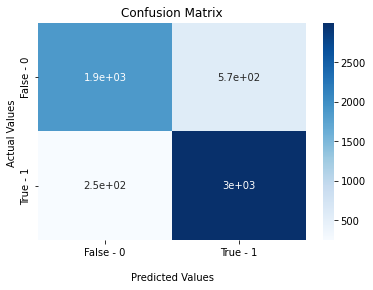

In [41]:
from sklearn.metrics import confusion_matrix

#first is category 0 then category 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, X_test_p.round())
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False - 0','True - 1'])
ax.yaxis.set_ticklabels(['False - 0','True - 1'])

## Display the visualization of the Confusion Matrix.
plt.show()

From the previous we can see that number of user suggestions with value 1, which were misclassified is 251. And number of suggestions with value 0, which were misclassified is 574. And so:

- **Precision** (percentage of classified suggestions from category 1 by our model, where actual from class 1) = **84%** = 2997 / (2997+579)

- **Recall** (percentage of actual suggestions from category 1 which were correctly classified by our model) = **92.2%** = 2997 / (2997+251)

We will also look at some **diagnostic graphs** and then compare them with rest of models.


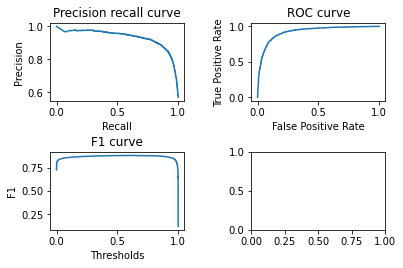

AUC score for (TPR, FPR) - graph:  0.9232
AUC-PR for (precision - recall) graph: 0.9335


In [49]:
diag_graphs(model, X_test_padded_NN, y_test)

# **Stacking**

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

def knn_inputer(X):

    X[X.isnull()] = np.nan

    imputer = KNNImputer(n_neighbors=2)
    X_im = imputer.fit_transform(X)
    return pd.DataFrame(X_im, columns = list(X.columns))

def process_dat(X):
  
  X_1 = X.loc[:,['title','developer','publisher']]
  X_1 = pd.get_dummies(X_1)
  X_1 = pd.concat([X_1,X.loc[:,['review_id','year']]], axis = 1)

  return X_1

X_trainm = process_dat(X_train)
X_trainm = knn_inputer(X_trainm)
X_trainm['predictions'] = [x[0] for x in X_train_pred.tolist()]

X_testm = process_dat(X_test)
X_testm = knn_inputer(X_testm)
X_testm['predictions'] = [x[0] for x in X_test_pred.tolist()]

print(X_trainm.isnull().sum())
print(X_testm.isnull().sum())

# 2. **Bidirectional LSTM** (+ CNN) with removing stop words and lematization


In [22]:
X_train.text.values[100].replace('\'','')

'Dota 2Valve Valve \'Free to Play\', \'MOBA\', \'Strategy\', \'Multiplayer\', \'Team-Based\', \'Action\', \'e-sports\', \'Online Co-Op\', \'Competitive\', \'PvP\', \'RTS\', \'Difficult\', \'RPG\', \'Fantasy\', \'Tower Defense\', \'Co-op\', \'Character Customization\', \'Replay Value\', \'Action RPG\', \'Simulation\'The most-played game on Steam.Every day, millions of players worldwide enter battle as one of over a hundred Dota heroes. And no matter if it\'s their 10th hour of play or 1,000th, there\'s always something new to discover. With regular updates that ensure a constant evolution of gameplay, features, and heroes, Dota 2 has truly taken on a life of its own.One Battlefield. Infinite Possibilities.When it comes to diversity of heroes, abilities, and powerful items, Dota boasts an endless array—no two games are the same. Any hero can fill multiple roles, and there\'s an abundance of items to help meet the needs of each game. Dota doesn\'t provide limitations on how to play, it em

In [ ]:
def process_test(x):
  
  lemmatizer = WordNetLemmatizer()
  
  x = x.replace("'re",'are')
  x = x.replace("'s",'is')
  x = x.replace("'n",'not')
  x = x.replace("'n",'not')

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(x)

  filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w.lower() in stop_words]
  
  return " ".join(filtered_sentence)

In [ ]:
for x in skuska:
  print(x)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
df_train_merged['text'] = df_train_merged.tags.apply(lambda x: x[1:-1]) + df_train_merged.overview + df_train_merged.user_review

X = df_train_merged
y = X.user_suggestion.values
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [ ]:
print("The longest sequence is {} words long.".format(max([len(x) for x in X_train_NN])))
pd.DataFrame([len(x) for x in X_train_NN]).describe()

In [ ]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 10000
#training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_NN)

print('Vocabulary is {} words large'.format(len(tokenizer.word_index)))

In [ ]:
sorted(tokenizer.word_counts.items(), key = lambda t: t[1])[47000:]

In [ ]:
X_train_NN = tokenizer.texts_to_sequences(X_train_NN)
X_train_padded_NN = np.array(pad_sequences(X_train_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test_NN = tokenizer.texts_to_sequences(X_test_NN)
X_test_padded_NN = np.array(pad_sequences(X_test_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential()

model.add(Embedding(vocab_size,240, input_length = max_length))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Flatten()),
Dropout(0.5),
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = METRICS)

model.summary()

In [ ]:
history = model.fit(X_train_padded_NN, y_train, epochs=1, validation_data=(X_test_padded_NN, y_test), verbose = 1)

In [ ]:
X_train_pred = model.predict(X_train_padded_NN)
X_test_pred = model.predict(X_test_padded_NN)

In [ ]:
from sklearn.metrics import confusion_matrix

#first is category 0 then catgory 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, round(X_test_p))
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

def knn_inputer(X):

    X[X.isnull()] = np.nan

    imputer = KNNImputer(n_neighbors=2)
    X_im = imputer.fit_transform(X)
    return pd.DataFrame(X_im, columns = list(X.columns))

def process_dat(X):
  
  X_1 = X.loc[:,['title','developer','publisher']]
  X_1 = pd.get_dummies(X_1)
  X_1 = pd.concat([X_1,X.loc[:,['review_id','year']]], axis = 1)

  return X_1

X_trainm = process_dat(X_train)
X_trainm = knn_inputer(X_trainm)
X_trainm['predictions'] = [x[0] for x in X_train_pred.tolist()]

X_testm = process_dat(X_test)
X_testm = knn_inputer(X_testm)
X_testm['predictions'] = [x[0] for x in X_test_pred.tolist()]

print(X_trainm.isnull().sum())
print(X_testm.isnull().sum())